In [1]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE"

/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE


# IMPORT LIBRARIES AND DATASETS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files 
%matplotlib inline


In [3]:
# data containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/train.csv')


In [4]:
# data containing defective and non defective images
all_images_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/defect_and_no_defect.csv')


EncodedPixels column is the encoding of the segmentation using RLE or "Run Length Encoding". This is a lossless data compression technique which stores sequences that contain many consecutive data element as a signle value followed by the occurence count.

In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


The ClassId column indicates which type of defect is found on corresponding image.

In [ ]:
set(defect_class_mask_df.ClassId)

{1, 2, 3, 4}

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


The label column indicates whether there is a defect or not for the corresponding image

In [ ]:
set(all_images_df.label)

{0, 1}

In [ ]:
all_images_df.label.sum()

7095

There are over 7,000 images with a defect in our dataset of nearly 13,000 images

# VISUALIZE AND EXPLORE DATASET

In [5]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [ ]:
defect_class_mask_df.head(10)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


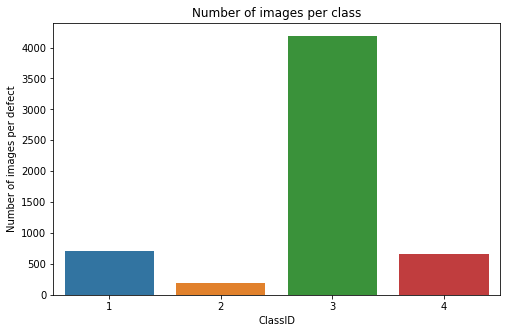

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data= defect_class_mask_df, x='ClassId')
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')
plt.show()

The defect type 3 is over-represented vs the other types. This can penalize the classification performance during training.
- Class 3 represents 73% of the defects

In [ ]:
defect_class_mask_df.groupby('ClassId').mask.count()/len(defect_class_mask_df)*100

ClassId
1    12.352122
2     3.392484
3    72.860125
4    11.395268
Name: mask, dtype: float64

In [ ]:
defect_class_mask_df.groupby('ImageId').mask.count().sort_values(ascending=False)

ImageId
ef24da2ba.jpg    3
4edc8b817.jpg    2
8bc5aeca3.jpg    2
8d2e8b456.jpg    2
adc257b59.jpg    2
                ..
a886bfcfc.jpg    1
a88757126.jpg    1
a8b77ce4d.jpg    1
a8bc0275d.jpg    1
0002cc93b.jpg    1
Name: mask, Length: 5474, dtype: int64

In [ ]:
# Some images are classified with more than one defect, let's explore this futher
# we have one image with 3 types of defects 
# we have 272 images with 2 types of defects
# we have 5201 images with 1 type of defect
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [ ]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [ ]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

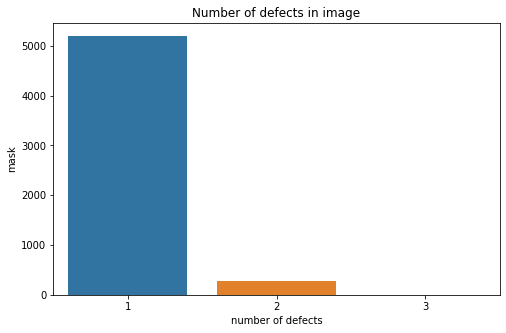

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('number of defects')
plt.title('Number of defects in image')

Most images have only 1 defect

In [ ]:
defect_class_mask_df.shape

(5748, 4)

In [ ]:
all_images_df.shape

(12997, 2)

In [ ]:
# Let's count defective and non defective images
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

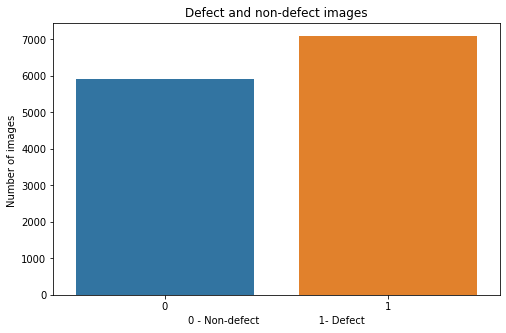

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect                   1- Defect')
plt.title('Defect and non-defect images')

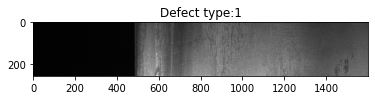

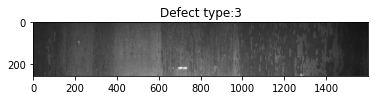

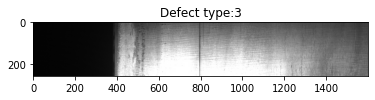

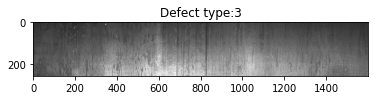

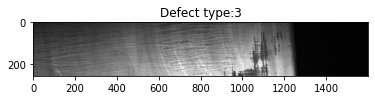

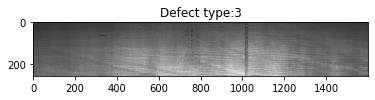

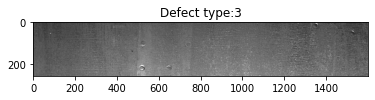

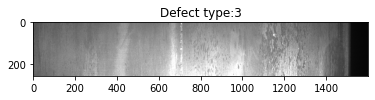

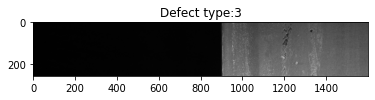

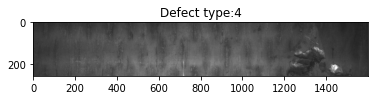

In [ ]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/train_images/'

for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title('Defect type:'+str(defect_class_mask_df.ClassId[i]))
  plt.imshow(img)


## Localize the defect : Image segmentation

In [6]:
from google.colab import files
files.upload() 

Saving utilities.py to utilities.py


{'utilities.py': b'\nimport pandas as pd\nimport numpy as np\nimport seaborn as sns\nimport cv2\nimport tensorflow as tf\nimport os \nfrom skimage import io\nfrom PIL import Image\nfrom tensorflow.keras import backend as K\n  \n#creating a custom datagenerator:\n\nclass DataGenerator(tf.keras.utils.Sequence):\n  def __init__(self, ids , list_class, list_rle, image_dir, batch_size = 16, img_h = 256, img_w = 256, shuffle = True):\n\n    self.ids = ids\n    self.class_type = list_class\n    self.rle = list_rle\n    self.image_dir = image_dir\n    self.batch_size = batch_size\n    self.img_h = img_h\n    self.img_w = img_w\n    self.shuffle = shuffle\n    self.on_epoch_end()\n\n  def __len__(self):\n    \'Get the number of batches per epoch\'\n\n    return int(np.floor(len(self.ids)) / self.batch_size)\n\n  def __getitem__(self, index):\n    \'Generate a batch of data\'\n\n    #generate index of batch_size length\n    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_s

In [7]:
# Utilities file contains the code for rle2mask, mask2rle, custom loss function and custom data generator
# since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask. 
# we can convert the mask back again to RLE to assess model performance (accuracy).
# Code source for these function came from: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
import sys
import os
py_file_location = "/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/"
sys.path.append(os.path.abspath(py_file_location))

#%cd /content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE
from utilities import rle2mask , mask2rle

train_dir = '/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/train_images/'

In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [ ]:
# Let's try to use the rle2mask on a sample image 
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

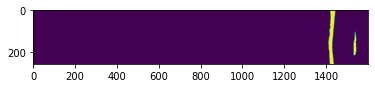

In [ ]:
# Let's show the mask
plt.imshow(mask)

(256, 1600, 3)

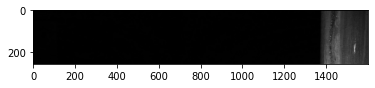

In [ ]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

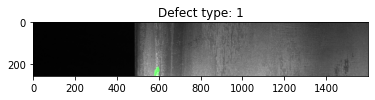

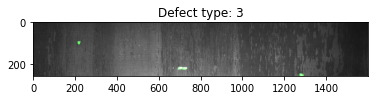

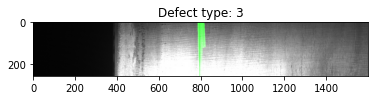

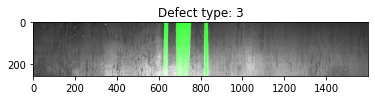

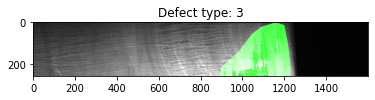

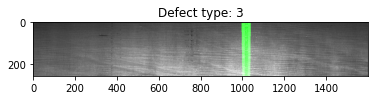

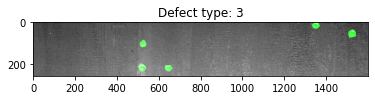

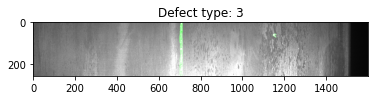

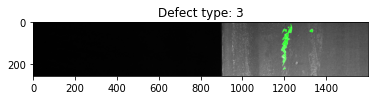

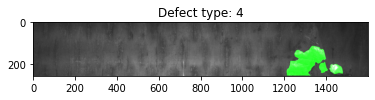

In [ ]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Let's color the pixels with values = 1 - We use the channel 1 or Green
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title('Defect type: '+ str(defect_class_mask_df.ClassId[i]))


# BUILD AND TRAIN A DEEP LEARNING MODEL TO DETECT WHETHER A DEFECT IS PRESENT IN AN IMAGE OR NOT

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [8]:
# split the data (defective and non defective) into training and testing 
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [ ]:
train.shape

(11047, 2)

In [ ]:
test.shape

(1950, 2)

In [9]:
train_dir = '/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/train_images/'


In [10]:
# create a image generator for the training and validation dataset
# we will divide the data to training, validation and testing
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))   # Input size required by ResNet model


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256),)


Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [11]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))



Found 1950 validated image filenames.


In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## The typical transfer-learning workflow
- https://keras.io/guides/transfer_learning/

In [15]:
# freeze the model weights
for layer in basemodel.layers:
  layer.trainable = False

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [17]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [18]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# (WARNING TAKES LONG TIME (~90 mins)!)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, 
                              validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.7823
Epoch 00001: val_loss improved from inf to 1.10059, saving model to resnet-weights.hdf5
586/586 [==============================] - 6741s 12s/step - loss: 0.5105 - accuracy: 0.7823 - val_loss: 1.1006 - val_accuracy: 0.4478
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8392
Epoch 00002: val_loss improved from 1.10059 to 0.47946, saving model to resnet-weights.hdf5
586/586 [==============================] - 153s 262ms/step - loss: 0.3659 - accuracy: 0.8392 - val_loss: 0.4795 - val_accuracy: 0.7743
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8667
Epoch 00003: val_loss improved from 0.47946 to 0.42682, saving model to resnet-weights.hdf5
586/586 [==============================] - 154s 262ms/step - loss: 0.3148 - accuracy: 0.8667 - 

In [ ]:
# save the trained model architecture for future use

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

# ASSESS TRAINED MODEL PERFORMANCE

In [19]:
with open('/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
# Make prediction (WARNING TAKES LONG TIME (~10 mins)!)
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 1386s 11s/step


In [ ]:
test_predict

array([[4.6225754e-03],
       [1.6978518e-11],
       [8.0846477e-01],
       ...,
       [9.9572939e-01],
       [9.9652427e-01],
       [2.3438504e-02]], dtype=float32)

In [ ]:
# Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
# The network is initially used to classify whether the image has defect or not
# Then these images (defective) is passed through the segmentation network to get the localization and type of defect. 
# Let's choose 0.01, to make sure, that we omit images from passing through the segmentation network only we are highly certain that it has no defect and if we are not confident, we can pass this image through the segmentation 
# network

predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [ ]:
len(predict)

1936

In [ ]:
# since we have used test generator, it limited the images to 1936, due to batch size
original = np.asarray(test.label)[:1936]
len(original)

1936

In [ ]:
# Find the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8842975206611571

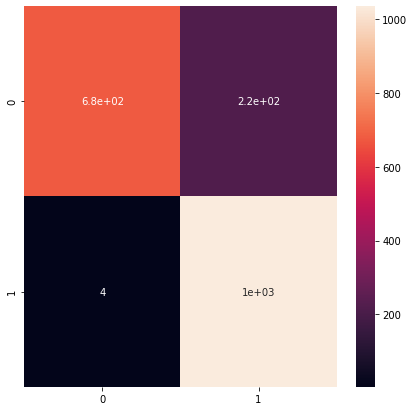

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Print the classification report

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       898
           1       0.82      1.00      0.90      1038

    accuracy                           0.88      1936
   macro avg       0.91      0.88      0.88      1936
weighted avg       0.90      0.88      0.88      1936



# BUILD A RES-U-NET SEGMENTATION MODEL

In [ ]:
#spliting the data into train and test data
X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [ ]:
#creating separate list for imageId, classId and rle to pass into the generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [ ]:
from utilities import DataGenerator

#creating image generators
training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


In [ ]:
def resblock(X, f):

  # making a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


## Loss function:
 
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/

from utilities import focal_tversky, tversky_loss, tversky

/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE


In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

Epoch 1/40
287/287 [==============================] - ETA: 0s - loss: 0.9339 - tversky: 0.0869
Epoch 00001: val_loss improved from inf to 0.87792, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 123s 430ms/step - loss: 0.9339 - tversky: 0.0869 - val_loss: 0.8779 - val_tversky: 0.1590
Epoch 2/40
287/287 [==============================] - ETA: 0s - loss: 0.7274 - tversky: 0.3430
Epoch 00002: val_loss improved from 0.87792 to 0.66480, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 119s 415ms/step - loss: 0.7274 - tversky: 0.3430 - val_loss: 0.6648 - val_tversky: 0.4178
Epoch 3/40
287/287 [==============================] - ETA: 0s - loss: 0.6317 - tversky: 0.4560
Epoch 00003: val_loss improved from 0.66480 to 0.60222, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 118s 411ms/step - loss: 0.6317 - tversky: 0.4560 - val_loss: 0.6022 - val_tversky: 0.4898
Ep

KeyboardInterrupt: ignored

In [ ]:
# save the model for future use

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

# TASK #9: ASSESS TRAINED SEGMENTATION MODEL PERFORMANCE

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# data containing test images for segmentation task 
test_df = pd.read_csv('test.csv')

In [ ]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [ ]:
from utilities import prediction

# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [ ]:
# create a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


	Ground truth 					Prediction


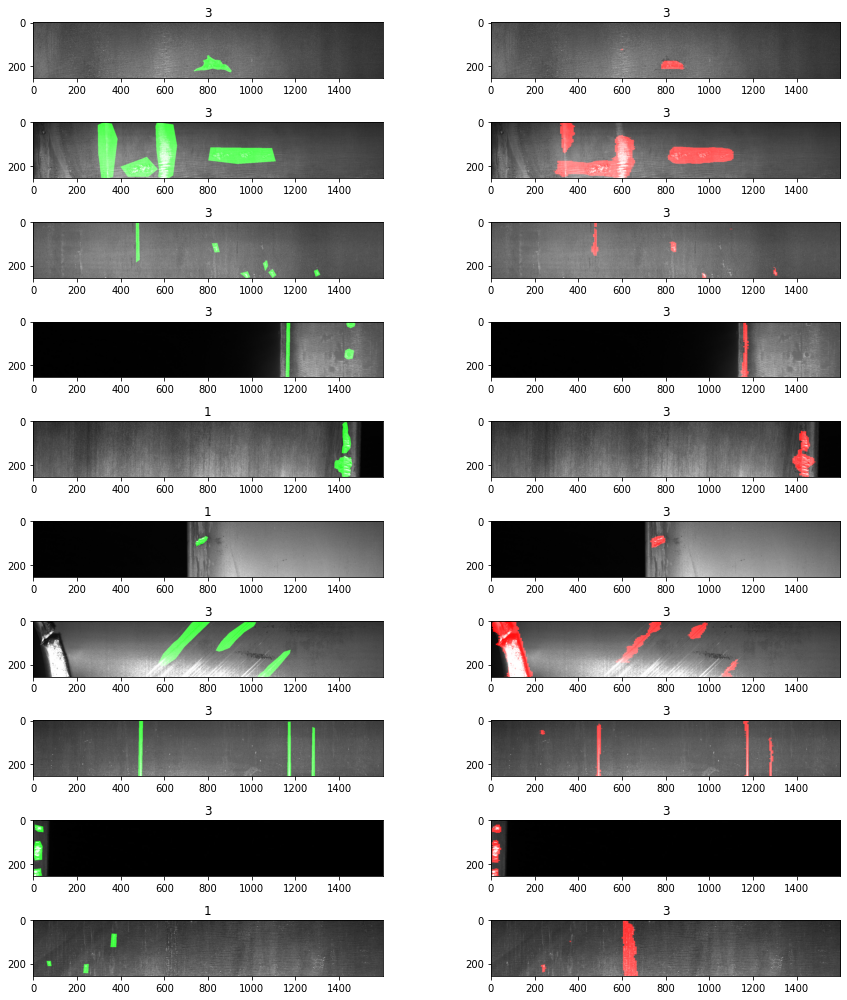

In [ ]:
# Let's show the images along with their original (ground truth) masks
directory = "train_images"
fig, axes = plt.subplots(10, 2, figsize = (14, 14))
axes = axes.ravel()    # convert 2D axes into 1D for below for loop
print('\tGround truth', '\t\t\t\t\tPrediction')
for i in range(10):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # read the images using opencv and convert to rgb format
  pred_img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  pred_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  # get the mask for the image from rle
  mask_pred = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  pred_img[mask_pred == 1,0] = 255

  plt.title(test_df.ClassId[i])

  axes[2*i].set_title(test_df.ClassId[i])
  axes[2*i].imshow(img)
  axes[2*i+1].set_title(df_pred.ClassId[i])
  axes[2*i+1].imshow(pred_img)
  plt.tight_layout()
